# scGPT annotation of H9 and CFS with pre-trained scGPT_human model

In this notebook, you can find the cell type annotation of H9 and the [CFS dataset](https://doi.org/10.1101/2024.03.26.586760) using [scGPT](https://doi.org/10.1038/s41592-024-02201-0).  
Embedding was performed using [cell_embed.py](https://github.com/bowang-lab/scGPT/blob/main/scgpt/tasks/cell_emb.py), after which the cell embeddings were compared with a similary search to the cell embeddings of the pre-trained scGPT_human that contains annotated cell types.  
Through majority voting, the final cell type annotation is chosen for each cell. A tutorial can be found through [this link](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb).  
This work was performed using the compute resources from the Academic Leiden Interdisciplinary Cluster Environment (ALICE) provided by Leiden University.

In [1]:
# Imports
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Set directory
os.chdir('C:/Users/jzuyd/scgpt/scGPT/code_cecile/figures')

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
h9 = sc.read_h5ad('h9.h5ad')
day0 = sc.read_h5ad('day0.h5ad')
day2 = sc.read_h5ad('day2.h5ad')
day14 = sc.read_h5ad('day14.h5ad')
day28 = sc.read_h5ad('day28.h5ad')

In [ ]:
# List of datasets and celltype keys
datasets = [h9, day0, day2, day14, day28]
celltypes_keys = ['celltypes_scgpt', 'celltypes_scgpt_hvg']

# Apply reduce_celltypes to each combination of dataset and celltypes_key
for dataset in datasets:
    for celltypes_key in celltypes_keys:
        print(dataset.obs[celltypes_key].value_counts())
        
# Conclusion: there are many celltypes that are only present once, so we need a function to apply a threshold in order to improve visualizations later on 

celltypes_scgpt
hepatocyte                             5747
germ cell                              1488
mesothelial cell                        751
granulosa cell                          114
primordial germ cell                    114
epithelial cell                         104
epithelial cell of lung                  95
native cell                              61
ovarian surface epithelial cell          55
glial cell                               41
migratory enteric neural crest cell      24
mesenchymal cell                         19
cortical thymic epithelial cell          14
neural crest cell                        12
neural cell                               8
epithelial cell of nephron                5
progenitor cell                           3
neuroblast (sensu Vertebrata)             3
Sertoli cell                              2
myoepithelial cell of mammary gland       2
mesodermal cell                           2
keratinocyte                              2
myofibroblast ce

In [ ]:
# Function to reduce the amount of cell type labels
def reduce_celltypes(adata, celltypes_key, threshold=84):
    """
    Consolidate small cell type labels into 'other'.
    
    Parameters:
    adata (AnnData): The annotated data matrix.
    celltypes_key (str): The key for cell types in adata.obs.
    threshold (int, optional): The threshold below which cell types are consolidated. Default is 50.
    
    Returns:
    None: The function modifies the adata object in place.
    """
    counts = adata.obs[celltypes_key].value_counts()
    small_labels = counts[counts < threshold].index

    adata.obs[celltypes_key] = adata.obs[celltypes_key].astype(str)
    adata.obs[celltypes_key] = adata.obs[celltypes_key].apply(lambda x: 'other' if x in small_labels else x)

# Apply reduce_celltypes to each combination of dataset and celltypes_key
for dataset in datasets:
    for celltypes_key in celltypes_keys:
        reduce_celltypes(dataset, celltypes_key)


In [ ]:
# Function to plot UMAP with custom palette
def plot_umap(dataset, celltypes_key, ax, title):
    unique_celltypes = dataset.obs[celltypes_key].unique()
    n_celltypes = len(unique_celltypes)
    
    # Define a colorblind-friendly palette with the required number of colors
    custom_palette = sns.color_palette("tab20", n_celltypes)
    
    # Ensure we have enough colors
    if n_celltypes > len(custom_palette):
        raise ValueError("Not enough colors in the palette for the number of cell types.")
    
    # Create a color map from the palette
    celltype_colors = {celltype: custom_palette[i] for i, celltype in enumerate(unique_celltypes)}
    
    # Plot UMAP with custom colors
    sc.pl.umap(dataset, color=celltypes_key, palette=celltype_colors, ax=ax, show=False)
    ax.set_title(title)

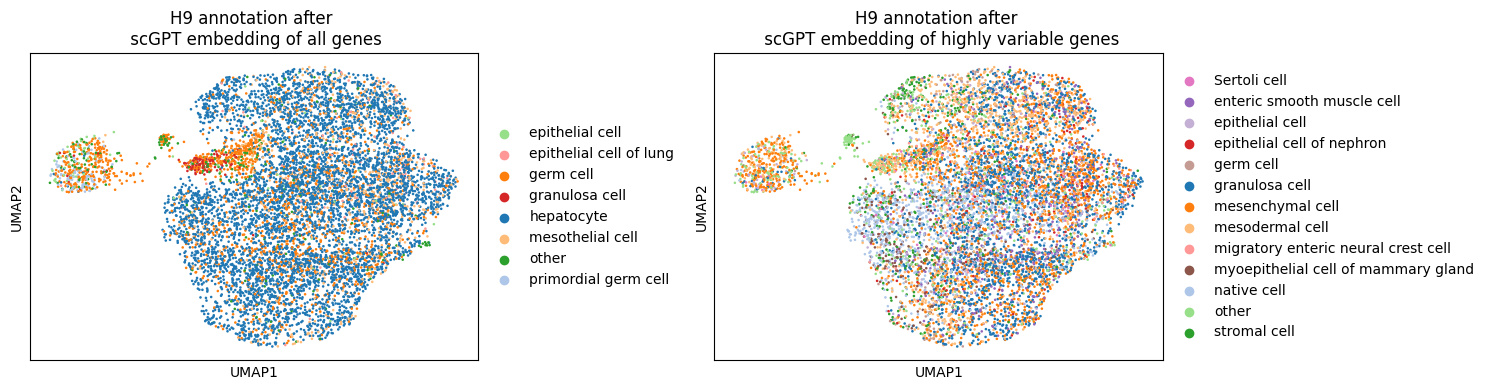

In [ ]:
### H9 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(h9, 'celltypes_scgpt', axes[0], 'H9 annotation after \n scGPT embedding of all genes')
plot_umap(h9, 'celltypes_scgpt_hvg', axes[1], 'H9 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

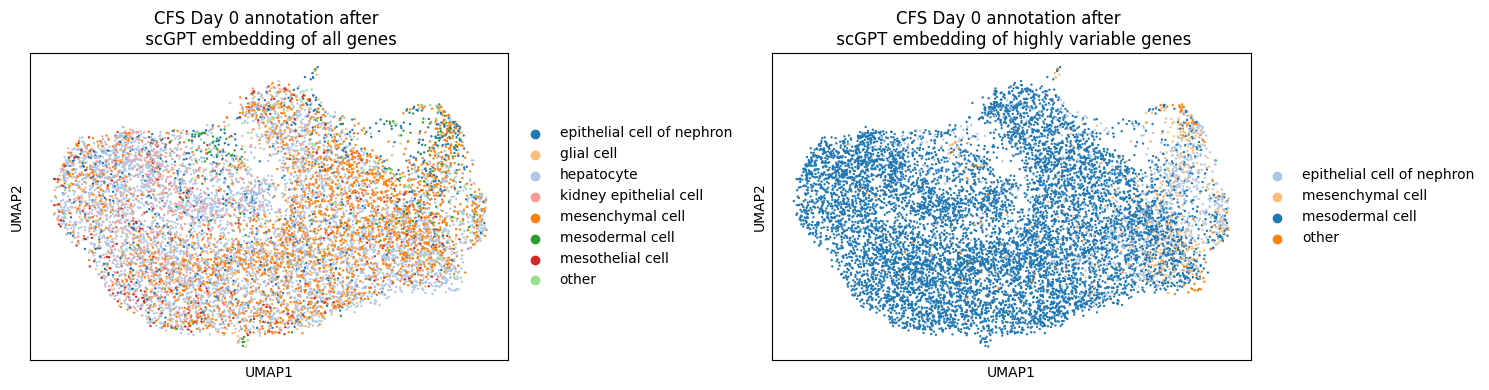

In [ ]:
### Day0 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day0, 'celltypes_scgpt', axes[0], 'CFS Day 0 annotation after \n scGPT embedding of all genes')
plot_umap(day0, 'celltypes_scgpt_hvg', axes[1], 'CFS Day 0 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

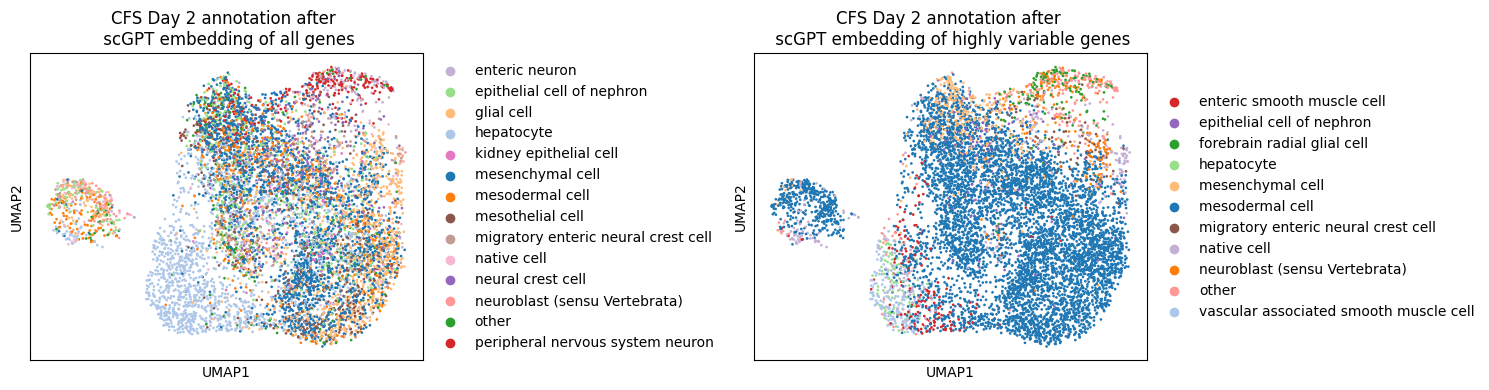

In [ ]:
### Day2 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day2, 'celltypes_scgpt', axes[0], 'CFS Day 2 annotation after \n scGPT embedding of all genes')
plot_umap(day2, 'celltypes_scgpt_hvg', axes[1], 'CFS Day 2 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

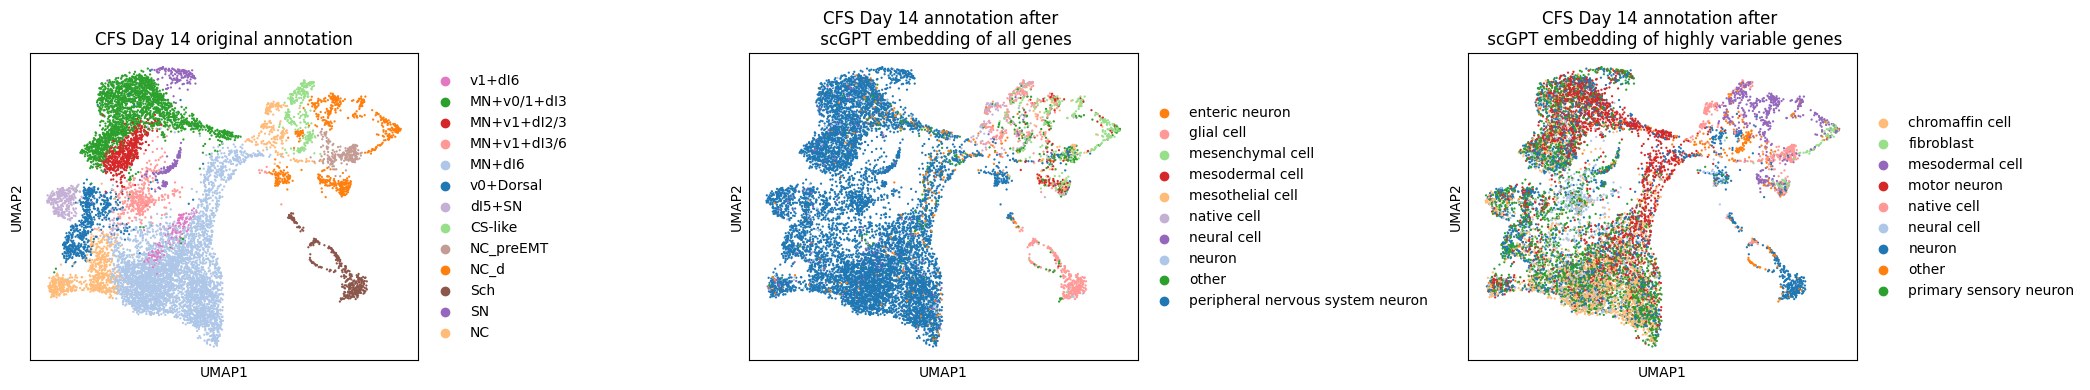

In [ ]:
### Day14 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(21, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day14, 'celltypes_original', axes[0], 'CFS Day 14 original annotation')
plot_umap(day14, 'celltypes_scgpt', axes[1], 'CFS Day 14 annotation after \n scGPT embedding of all genes')
plot_umap(day14, 'celltypes_scgpt_hvg', axes[2], 'CFS Day 14 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

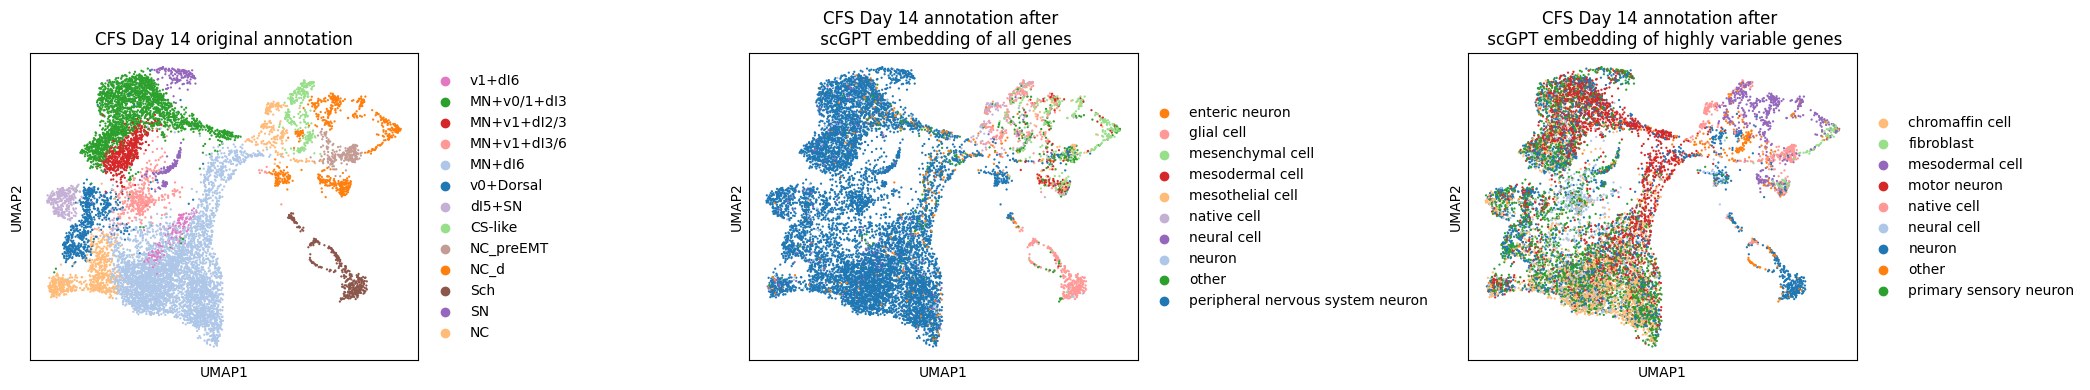

In [ ]:
### Day14 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(21, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day14, 'celltypes_original', axes[0], 'CFS Day 14 original annotation')
plot_umap(day14, 'celltypes_scgpt', axes[1], 'CFS Day 14 annotation after \n scGPT embedding of all genes')
plot_umap(day14, 'celltypes_scgpt_hvg', axes[2], 'CFS Day 14 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

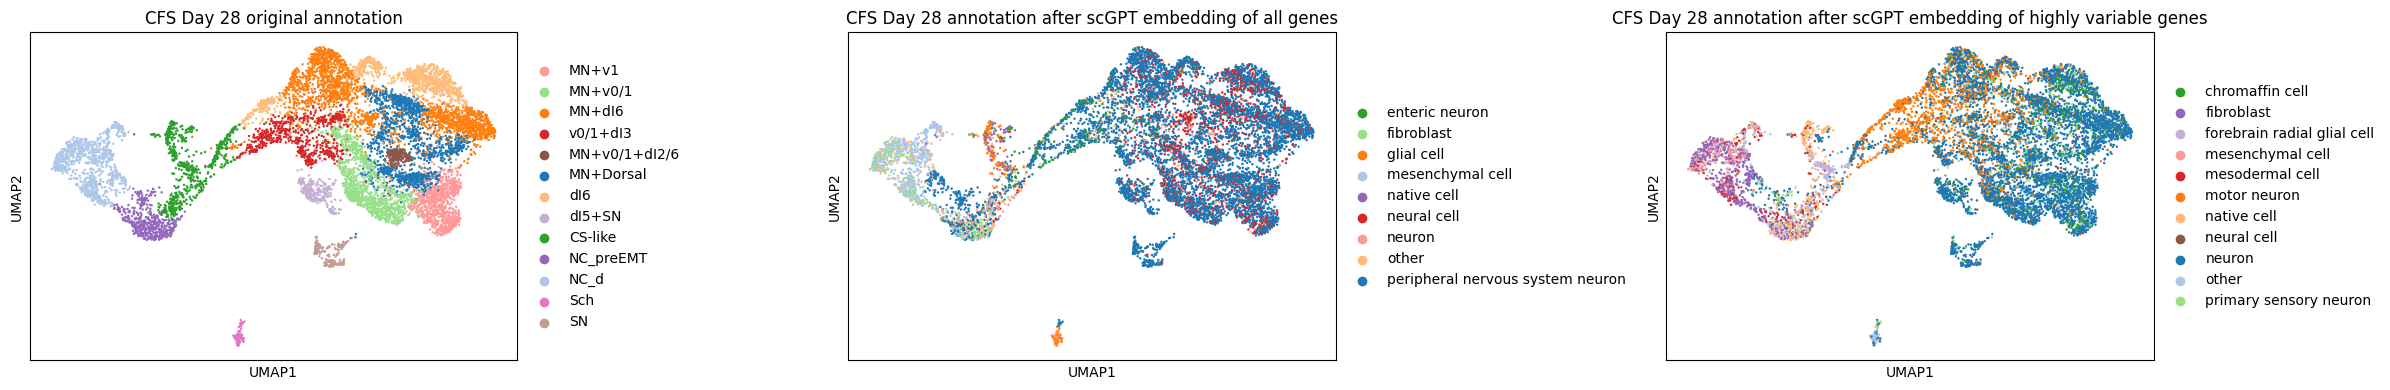

In [ ]:
### Day28 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day28, 'celltypes_original', axes[0], 'CFS Day 28 original annotation')
plot_umap(day28, 'celltypes_scgpt', axes[1], 'CFS Day 28 annotation after scGPT embedding of all genes')
plot_umap(day28, 'celltypes_scgpt_hvg', axes[2], 'CFS Day 28 annotation after scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()